In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import astropy.units as u 

from astropy.coordinates import SkyCoord
from astropy.time import Time
from astroplan import Observer, FixedTarget, time_grid_from_range
from astroplan.plots import plot_airmass

from astropy.table import Table

from ztfquery import fields



>>> from astroplan import download_IERS_A
>>> download_IERS_A()
 [astroplan.utils]


In [2]:
#get number of i-band exposures
iband_numexp = np.loadtxt('iband_Nobs_fromDanny.txt')
odict_iband = {}
for i in iband_numexp:
    odict_iband[str(int(i[0]))] = i[1]
#print(odict_iband)

In [3]:
#fields between 180 and 270 degrees
target_table = Table.read('fields.txt', format='ascii')
tar_tab = target_table[['%ID', 'RA', 'Dec', 'Ebv']]
cond = (tar_tab['RA'] > 170) & (tar_tab['RA'] < 270) & (tar_tab['%ID'] < 879)
fid = tar_tab['%ID'][cond]
ra = tar_tab['RA'][cond]
dec = tar_tab['Dec'][cond]
ebv = tar_tab['Ebv'][cond]
print(fid)

%ID
---
  3
 10
 11
 12
 24
 25
 26
 27
 28
 44
...
845
846
847
848
861
862
863
864
873
874
875
Length = 244 rows


In [5]:
aam_observe = np.loadtxt('AllObservability_JanApr.txt')
#an array of zeros corresponding to the total number of fields in the primary + secondary grid
#index for the array is fid - 1
field_obs = np.zeros([len(aam_observe)])
N_night_field = []

for i, fidval in enumerate(fid):
    num_existing = 0
    obs_list_2hr = aam_observe[fidval-1][aam_observe[fidval-1] > 2./24.]
    N_nights_2hr = len(obs_list_2hr)
    tot_hrs_obs = np.sum(obs_list_2hr)
    field_obs[fidval-1] = np.sum(aam_observe[fidval-1])*24.
    if float(fidval) in iband_numexp[:,0]:
        num_existing = iband_numexp[iband_numexp[:,0] == float(fidval)][0][1]
    else:
        pass
    #if ra[i] > 220:
    #    print(fidval, obs_list_2hr[-30:-15]*24.)
    N_night_field.append([fidval, N_nights_2hr, tot_hrs_obs*24., ra[i], dec[i], ebv[i], num_existing])

#print(field_obs[11:875])
N_night_field = np.array(N_night_field)
#print(N_night_field)
#print(np.shape(aam_observe))
times = time_grid_from_range(Time(["2020-01-01 00:00", "2020-04-15 00:00"]), time_resolution=1*u.day)
times_all = time_grid_from_range(Time(["2020-01-01 00:00", "2020-04-15 00:00"]), time_resolution=1*u.day)
twed_jd = times.jd
tall_jd = times_all.jd

#get the coordinates, number of hours observable and number of nights above 2 hours of observability for each
#field that is observable for more than 2 hours on a given night
#order these by total observability

DR8_overlap_Fid =  N_night_field[N_night_field[:,4] < 80.]
MostObs = N_night_field[N_night_field[:,2].argsort()]

MostObs_DR8 = DR8_overlap_Fid[DR8_overlap_Fid[:,2].argsort()]
#print(MostObs)
print(MostObs_DR8[-45:][:,-2])
#print(len(N_night_field[N_night_field[:,1] >= 95]))
#print(N_night_field[:,2][N_night_field[:,1] >= 95])
#print(N_night_field[:,-1][N_night_field[:,1] >= 95])

fin_dict, obs_dict, obs_dict_DR8 = {}, {}, {}
N_night_field_obscut = N_night_field[N_night_field[:,1] >= 95]
for i in N_night_field_obscut:
    if i[0] in MostObs[-45:]:
        print(i[0])
    fin_dict[str(int(i[0]))] = i[-1]
for i in MostObs_DR8[-45:]:
    obs_dict_DR8[str(int(i[0]))] = i[2]
for i in MostObs[-45:]:
    obs_dict[str(int(i[0]))] = i[2]

#print(len( MostObs[-45:]))
np.savetxt("MostObs_ZUDSFields_withObsVals.txt", MostObs[-45:])
np.savetxt("DR8_overlap_MostObs_ZUDSFields_withObsVals.txt", MostObs_DR8[-45:])

#print(fin_dict)

[0.01 0.02 0.01 0.02 0.02 0.02 0.01 0.02 0.01 0.02 0.04 0.03 0.02 0.02
 0.04 0.02 0.02 0.01 0.03 0.01 0.03 0.01 0.01 0.01 0.02 0.01 0.03 0.02
 0.02 0.01 0.02 0.02 0.01 0.02 0.02 0.02 0.01 0.02 0.02 0.02 0.01 0.03
 0.02 0.01 0.1 ]
673.0
674.0
716.0
717.0
718.0
719.0
754.0
755.0
756.0
757.0
758.0
759.0
789.0
790.0
791.0
792.0
793.0
819.0
820.0
821.0
822.0
843.0
844.0
845.0
846.0
861.0
862.0
863.0
873.0
874.0
875.0


[758. 759. 760. 791. 792. 793. 794. 820. 821. 822. 823. 843. 844. 845.
 846. 861. 862. 863. 864. 873. 874. 875.]


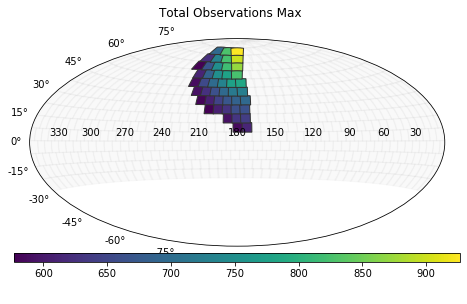

In [19]:
fid_arr_2hrcut = N_night_field[:,0][N_night_field[:,1] >= 105]
print(MostObs_DR8[:,0])
#fields.show_fields(fin_dict, title="Only 2hour cut > 95 days", edgecolor="0.2", vmin=0, vmax=50)
fields.show_fields(obs_dict_DR8, title="Total Observations Max", edgecolor="0.2")

plt.savefig("RA170_Total_Obs_max_DR8_overlap.jpg")
#plt.savefig("Only_ObsCut_2hr_95days_withNumObs.jpg")
#np.savetxt("Only_ObsCut_2hr_95Days_withNumObs.txt", N_night_field_obscut)

In [41]:
times = time_grid_from_range(Time(["2019-10-28 00:00", "2020-01-15 00:00"]), time_resolution=1*u.day)

#visibility of fields from now
all_obs_fromnow = np.loadtxt('Palomar_AllObservability_EndOctJan.txt')
print(all_obs_fromnow[823])
all_obs_ZUDS = np.loadtxt('AllObservability_JanApr.txt')
#print(MostObs_DR8[-45:][:,0])
#print(all_obs_ZUDS[822])
index_rise_array = []
#print(all_obs_fromnow[int(MostObs_DR8[-45:][:,0][1])])
for i in MostObs_DR8[-45:][:,0]:
    print(int(i))
    obs_array = all_obs_fromnow[int(i)-1]
    nonzero_array = obs_array[obs_array > 0.01] #0.01 day ~ 15 minutes
    
    #print(len(nonzero_array), obs_array)
    first_day_obs = nonzero_array[0]
    index_val = list(obs_array).index(first_day_obs)
    jd_firstday = times.jd[index_val]
    datetime_first = times[index_val]
    #print(index_val, jd_firstday, datetime_first)
    index_rise_array.append([i, index_val, jd_firstday, str(datetime_first.datetime.day)+'-'+str(datetime_first.datetime.month)+'-'+str(datetime_first.datetime.year)])
index_rise_array = np.array(index_rise_array)
index_sorted_fields = index_rise_array[index_rise_array[:,1].astype('float32').argsort()]
print(index_sorted_fields)

np.savetxt('Fields_ordered_byRise_forRef.dat', index_rise_array, fmt='%s')


[0.05416667 0.05138889 0.04930556 0.04722222 0.04513889 0.04305556
 0.04097222 0.03819444 0.03611111 0.03402778 0.03194444 0.02986111
 0.02777778 0.025      0.02291667 0.02083333 0.01805556 0.01597222
 0.01319444 0.01111111 0.00833333 0.00555556 0.00347222 0.00069444
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00069444 0.00347222 0.00694444 0.01041667 0.01319444 0.01666667
 0.01875    0.02222222 0.02569444 0.02847222 0.03194444 0.03472222
 0.03819444 0.04097222 0.04444444 0.04722222 0.05069444 0.05347222
 0.05694444 0.05972222 0.0625     0.06527778 0.06805556 0.07083333
 0.07361111 0.07708333 0.07986111 0.08263889 0.08541667 0.08819444
 0.09166667 0.09444444 0.09722222 0.1        0.10277778 0.10486111
 0.10763889]
627
823
675
524
759
576
719
626
674
793
523
846
718
625
575
574
673
758
624
717
623
822
672
792
671
716
863
670
757
715
714
845
756
821
791
